### Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.tri import Triangulation, LinearTriInterpolator
import ipywidgets as widgets
from ipywidgets import interactive, FloatSlider
from IPython.display import display

from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import UR_utils
from UR_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from DNN import Regressor

import os
import re
import time
from zipfile import ZipFile

from scipy import special
from scipy.interpolate import griddata

from matplotlib import rc
rc('mathtext', fontset='cm')

### Global variables

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.set_device(device)

selected_columns = ['cos(theta)', 'R_surf', 'dlogR_dtheta', 'g_surf', 'Rpole_num', 'Req_num', 
                    'Rpol/Req', 'ellipticity', 'eccentricity', 'rho_c', 'r_ratio', 'M', 'M(km)',
                    'Req', 'C', 'K', 'g_0(km^(-1))', 'Ibar', 'f(Hz)', 'f_tilde', 'Jgeom(km^2)',
                    'x', 'sigma', 'T/W', 'Mxf_tilde', 'Rxf_tilde', 'Qbar', 'S3bar', 'EoS']

selected_features = ['cos(theta)', 'C', 'sigma', 'Rpol/Req']

abs_mu_min, abs_mu_max = 0., 1. 
C_min, C_max = 0.0876346858172578, 0.3094541325480277
sigma_min, sigma_max = 0., 0.9612274013913829
eccentricity_min, eccentricity_max = 0., 0.7797886226038347
Rpol_Req_min, Rpol_Req_max = 0.6260428931452016, 1.0

min_values = np.array([abs_mu_min, C_min, sigma_min, Rpol_Req_min])
max_values = np.array([abs_mu_max, C_max, sigma_max, Rpol_Req_max])

feature_scaler = lambda data: (data - min_values) / (max_values - min_values)

N_MU = 521

#### Read Star Data

In [3]:
def read_zip(file_name, spin, test_percentage=0.2):
    # random seed for 'freezing' randomness
    SEED = 42
    rng = np.random.default_rng(SEED)
    
    # specifying the zip file name
    columns_names = ['cos(theta)', 'R_surf', 'dlogR_dtheta', 'g_surf', 'Rpole_num', 'Req_num', 'Rpol/Req',
                    'ellipticity', 'eccentricity', 'P_c', 'rho_c', 'r_ratio', 'r_e', 'M', 'M(km)',
                    'Req', 'C', 'K', 'g_0(km^(-1))', 'I(kgkm^2)', 'I(km^3)', 'Ibar', 'Z_p', 'Z_b',
                    'Z_f', 'Ω(Hz)', 'f(Hz)', 'f_tilde', 'Jgeom(km^2)', 'x', 'sigma', 'T/W',
                    'Mxf_tilde', 'Rxf_tilde', 'conv_rad', 'conv_plus', 'conv_minus', 'h_plus',
                    'h_minus', 'r_plus', 'r_minus', 'Q(km^3)', 'Qbar', 'S3(km^4)', 'S3bar', 'M4_geom',
                    'M4_asy^GH_geom', 'M4_asy_geom', 'M4_geom_2points', 'M4_geom_3points',
                    'M4_geom_4points', 'S5_geom', 'S5_asy_geom', 'EoS']
    
    minmax_scale = lambda dR_dtheta, dR_dtheta_min, dR_dtheta_max: (dR_dtheta - dR_dtheta_min) / (dR_dtheta_max - dR_dtheta_min)

    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    # opening the zip file in READ mode
    with ZipFile(file_name, 'r') as zip:
        # Pop the folder from the list of stars
        zip.infolist().pop(0)
        
        star_train, star_test = list(), list()
        n_stars = len(zip.infolist())
        n_test_stars = int(n_stars * test_percentage)
        test_indexes = rng.choice(n_stars, n_test_stars, replace=False)
        
        for index, star in enumerate(zip.infolist()):
            star = zip.extract(star)
            df_star = pd.read_csv(star, sep=' ', names=columns_names, skiprows=1)
            
            # Keep stars that only with r_ratio >= 0.6
            if df_star['r_ratio'].iloc[0] < 0.6: continue
            repeat_values = df_star.iloc[0].values
            df_star.iloc[1:, 4:] = repeat_values[4:]
            
            # Select only this columns to save memory
            df_star = df_star[selected_columns] 
            
            # Output normalization
            if np.all(df_star[spin] == 0.0):
                # Avoid zero division to static case
                df_star['dlogR_dtheta_scaled'] = 0.0
            else:
                # Min max scaling at star level
                df_star['dlogR_dtheta_scaled'] = minmax_scale(df_star['dlogR_dtheta'], 0.0, df_star['dlogR_dtheta'].max())
                                    
            if index in test_indexes:
                star_test.append(df_star)
            else:
                star_train.append(df_star)
                
        # Concat the dataframes to train and test
        if star_train: df_train = pd.concat(star_train, ignore_index=True)
        if star_test: df_test = pd.concat(star_test, ignore_index=True)
        
    return df_train, df_test

In [4]:
def load_stars(df, batch_size=4096, shuffle=True):
    df_target = df['dlogR_dtheta_scaled']
    
    np_features = df[selected_features].to_numpy()    
    np_targets = df_target.to_numpy()
    np_targets = np.reshape(np_targets, (np_targets.shape[0], 1))
    
    tr_features = torch.Tensor(feature_scaler(np_features))
    input_dimension = tr_features.shape[1]
    
    tr_targets = torch.Tensor(np_targets)
    final_dataset = TensorDataset(tr_features, tr_targets)

    # pin_memory=True, num_workers >= 1 if data is not already on device and model is training
    dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1, pin_memory=True)

    return dataloader, input_dimension, np_features, np_targets

### Evaluation: statistical evaluation measures

### Evaluation of the Logarithmic derivative ANN model performance to the whole NSs Dataset test set

In [5]:
df_eval_dataset = pd.read_csv('./Experimental Results/Derivative/dataset_measures.csv')
df_eval_dataset
#df_eval_dataset.to_latex(index = False, escape = False)

explained_variance  max_error  mean_absolute_error  mean_squared_error  \
0            0.999976    0.00836             0.000266        3.186803e-07   

   r2_score  mean_absolute_percentage_error  eval_eos_type  eval_eos_name  
0  0.999976                      23264224.0            NaN            NaN

### Evaluation of the Regression ANN model to the whole NS's data (per EOS level) on the test set

In [6]:
df_eval_eos = pd.read_csv('./Experimental Results/Derivative/EOS_measures.csv')
df_eval_eos = df_eval_eos.sort_values(by = ['eval_eos_type', 'eval_eos_name'])
df_eval_eos.reset_index(drop = True, inplace = True)
df_eval_eos
#df_eval_eos.to_latex(index = False, escape = False)

explained_variance  max_error  mean_absolute_error  mean_squared_error  \
0             0.999992   0.002905             0.000172        9.455648e-08   
1             0.999986   0.003635             0.000203        1.827745e-07   
2             0.999986   0.004378             0.000210        1.922628e-07   
3             0.999975   0.004886             0.000298        3.433152e-07   
4             0.999983   0.005017             0.000219        1.993735e-07   
..                 ...        ...                  ...                 ...   
65            0.999977   0.004800             0.000297        3.371826e-07   
66            0.999991   0.002656             0.000179        1.142386e-07   
67            0.999992   0.003068             0.000170        9.824574e-08   
68            0.999990   0.004050             0.000199        1.471445e-07   
69            0.999989   0.003393             0.000212        1.554367e-07   

    r2_score  mean_absolute_percentage_error eval_eos_type eval_eos_name  
0   0.999992                      46598380.0      Hadronic       BL_2018  
1   0.999986                      22160074.0      Hadronic         BSK22  
2   0.999986                      20966680.0      Hadronic         BSK24  
3   0.999974                      18877362.0      Hadronic         BSK25  
4   0.999982                      15456175.0      Hadronic         BSK26  
..       ...                             ...           ...           ...  
65  0.999975                      18291932.0     Hyperonic     DS(CMF)-3  
66  0.999991                      12745778.0     Hyperonic     DS(CMF)-5  
67  0.999992                      12089122.0     Hyperonic     DS(CMF)-7  
68  0.999990                      13917331.0     Hyperonic        GM1 Y5  
69  0.999989                      14820256.0     Hyperonic        GM1 Y6  

[70 rows x 8 columns]

### Evaluation measures for the trained ANN model to the star level [NSs at test dataset]

In [8]:
#note: follow the ./Experimental Results/Derivative/ path and unzip the error_star_level.zip file
df = pd.read_csv('./Experimental Results/Derivative/error_star_level.csv')

In [35]:
df

Unnamed: 0      residual  star_id        mu      Req         C  \
0                 0  1.334784e-06        0  0.000000  16.1732  0.207095   
1                 1 -3.184690e-04        0  0.001923  16.1732  0.207095   
2                 2 -7.212907e-05        0  0.003846  16.1732  0.207095   
3                 3 -2.482794e-04        0  0.005769  16.1732  0.207095   
4                 4  3.697407e-04        0  0.007692  16.1732  0.207095   
...             ...           ...      ...       ...      ...       ...   
4450898     4450898  7.830414e-29      128  0.992308  13.1933  0.217836   
4450899     4450899  1.249960e-40      128  0.994231  13.1933  0.217836   
4450900     4450900  0.000000e+00      128  0.996154  13.1933  0.217836   
4450901     4450901  0.000000e+00      128  0.998077  13.1933  0.217836   
4450902     4450902  0.000000e+00      128  1.000000  13.1933  0.217836   

            sigma  eccentricity  Rpol/Req  dlogR_dtheta_scaled eval_eos_type  \
0        0.735137  7.301570e-01  0.683279             0.000000     Hyperonic   
1        0.735137  7.301570e-01  0.683279             0.012673     Hyperonic   
2        0.735137  7.301570e-01  0.683279             0.024923     Hyperonic   
3        0.735137  7.301570e-01  0.683279             0.037454     Hyperonic   
4        0.735137  7.301570e-01  0.683279             0.049983     Hyperonic   
...           ...           ...       ...                  ...           ...   
4450898  0.000000  1.490116e-08  1.000000             0.000000        Hybrid   
4450899  0.000000  1.490116e-08  1.000000             0.000000        Hybrid   
4450900  0.000000  1.490116e-08  1.000000             0.000000        Hybrid   
4450901  0.000000  1.490116e-08  1.000000             0.000000        Hybrid   
4450902  0.000000  1.490116e-08  1.000000             0.000000        Hybrid   

                  eval_eos_name  
0                     DS(CMF)-5  
1                     DS(CMF)-5  
2                     DS(CMF)-5  
3                     DS(CMF)-5  
4                     DS(CMF)-5  
...                         ...  
4450898  OOS(DD2-FRG)-2 flavors  
4450899  OOS(DD2-FRG)-2 flavors  
4450900  OOS(DD2-FRG)-2 flavors  
4450901  OOS(DD2-FRG)-2 flavors  
4450902  OOS(DD2-FRG)-2 flavors  

[4450903 rows x 12 columns]

In [8]:
df_new = df[df['sigma'] !=0].copy()
df_new.reset_index(drop=True, inplace=True)


In [9]:
dlogR_min_max = df_new['dlogR_dtheta_scaled']

mu_var =  df_new['mu']
e_var =  df_new['eccentricity']
C_var =  df_new['C']
sigma_var =  df_new['sigma']

In [10]:
def Surface_plot(df, x,y,w, z, xlabel,ylabel,wlabel,zlabel, view2, n_col,
                         border_axes, X,Y,W, Z, l_w):
    
    fig = plt.figure(figsize=(20 ,16)) 
    labels_text_size = 40
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 35
    label_pad = 30
    label_size = 30

    mu_values = [0, 0.17692308,0.45769231,0.60384615, 0.78461538, 1]

    colors = ['green', 'pink', 'purple', 'cyan', 'brown','cyan']
    
    for i in range(0,len(mu_values)):
        scatter = ax.scatter(df[df['mu']==mu_values[i]][x].to_numpy(), df[df['mu']==mu_values[i]][y].to_numpy(),df[df['mu']==mu_values[i]][z].to_numpy(),
                   c = df[df['mu']==mu_values[i]][w].to_numpy(), s = dot_size, cmap='coolwarm', marker='o', alpha = 0.8)    
        
        triang = Triangulation(df[df['mu']==mu_values[i]][x].to_numpy(), df[df['mu']==mu_values[i]][y].to_numpy())
        interpolator = LinearTriInterpolator(triang, df[df['mu']==mu_values[i]][z].to_numpy())
        grid_x, grid_y = np.mgrid[0.0901155694351282:0.3062042574717896:500j, 0.0329041860812303:0.9416722276120412:500j]

        grid_z = interpolator(grid_x, grid_y)
        ax.plot_surface(grid_x, grid_y, grid_z, color = colors[i], alpha = 0.8, label = f'Interpolated surface with $\mu_\star$ = {np.round(mu_values[i],3)}', zorder = 5)

   
    # Add colorbar
    cbar = plt.colorbar(scatter,  shrink=0.45)
    cbar.set_label(wlabel, fontsize=font_size, rotation = 0)
    cbar.ax.tick_params(labelsize=23)

 
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    
    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad,rotation = 90) 

    ax.yaxis.labelpad = 25
    ax.zaxis.labelpad = 23
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(2)
    
    ax.grid(False)

    leg = plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 20},shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
    leg.get_frame().set_linewidth(3.0)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    
    plt.show()

### Universal description for fixed $\mu$ values

In [11]:
x = 'C'; y = 'sigma'; w = 'Rpol/Req' ;z = 'dlogR_dtheta_scaled' ; z_model = '';

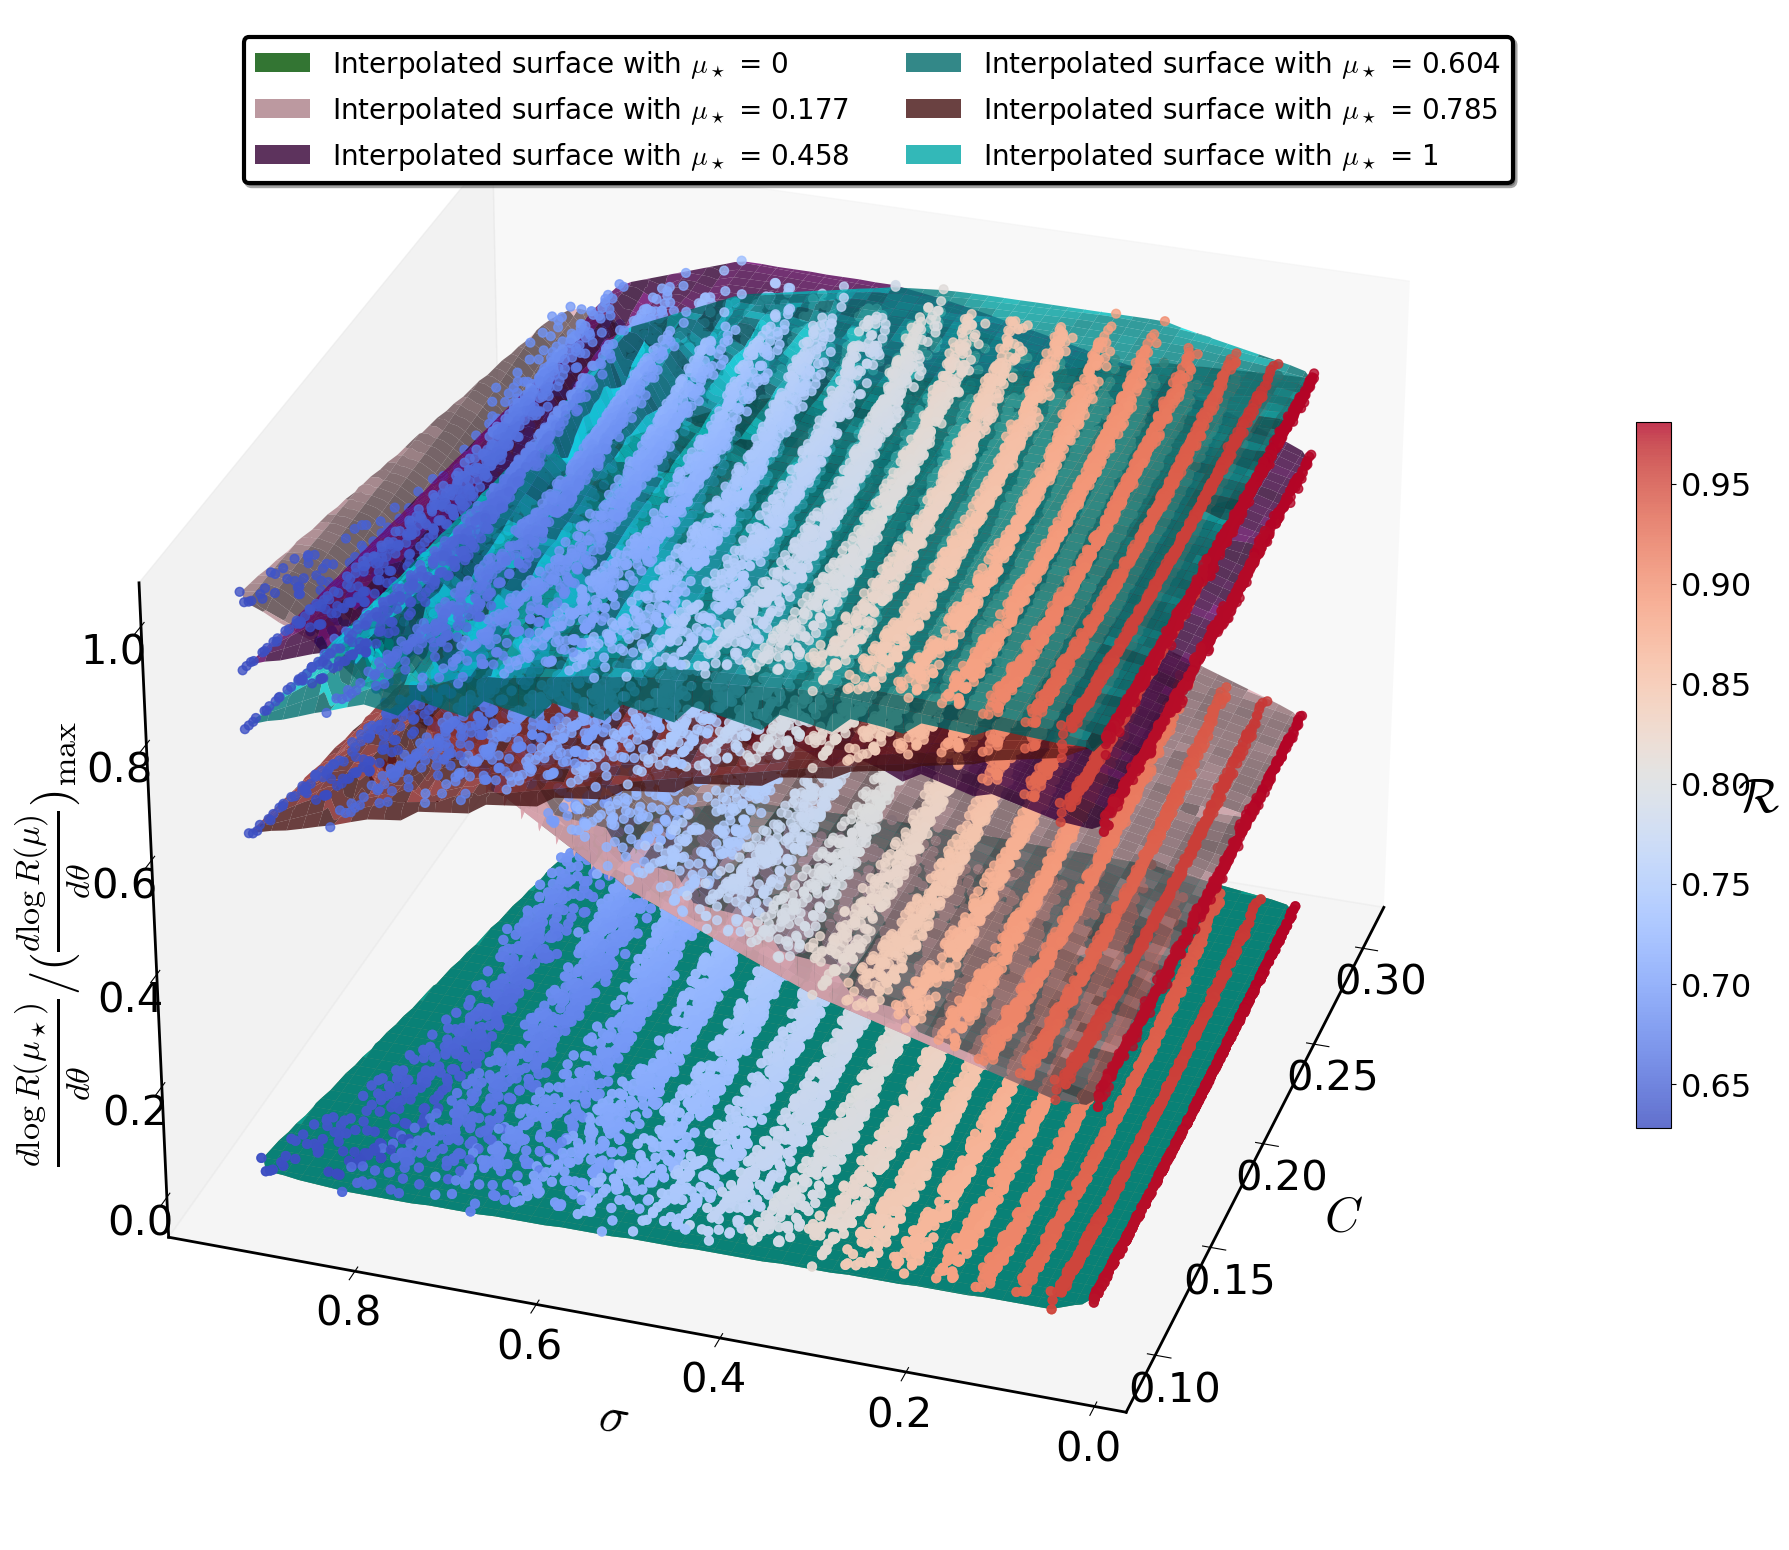

In [12]:
Surface_plot(df_new, x,y,w,z, xlabel=r'$C$',ylabel='$\sigma$',
                     wlabel = r'$\mathcal{R}$',
                     zlabel=r'$ \frac{d\log R(\mu_\star)}{d\theta}/(\frac{d\log R(\mu)}{d\theta})_{\mathrm{max}}$', 
                     view2=198, n_col=2, border_axes=1, X=None,Y=None,W = None,Z=None, l_w=1.5) #197

### Universal description for each $\mu$ value

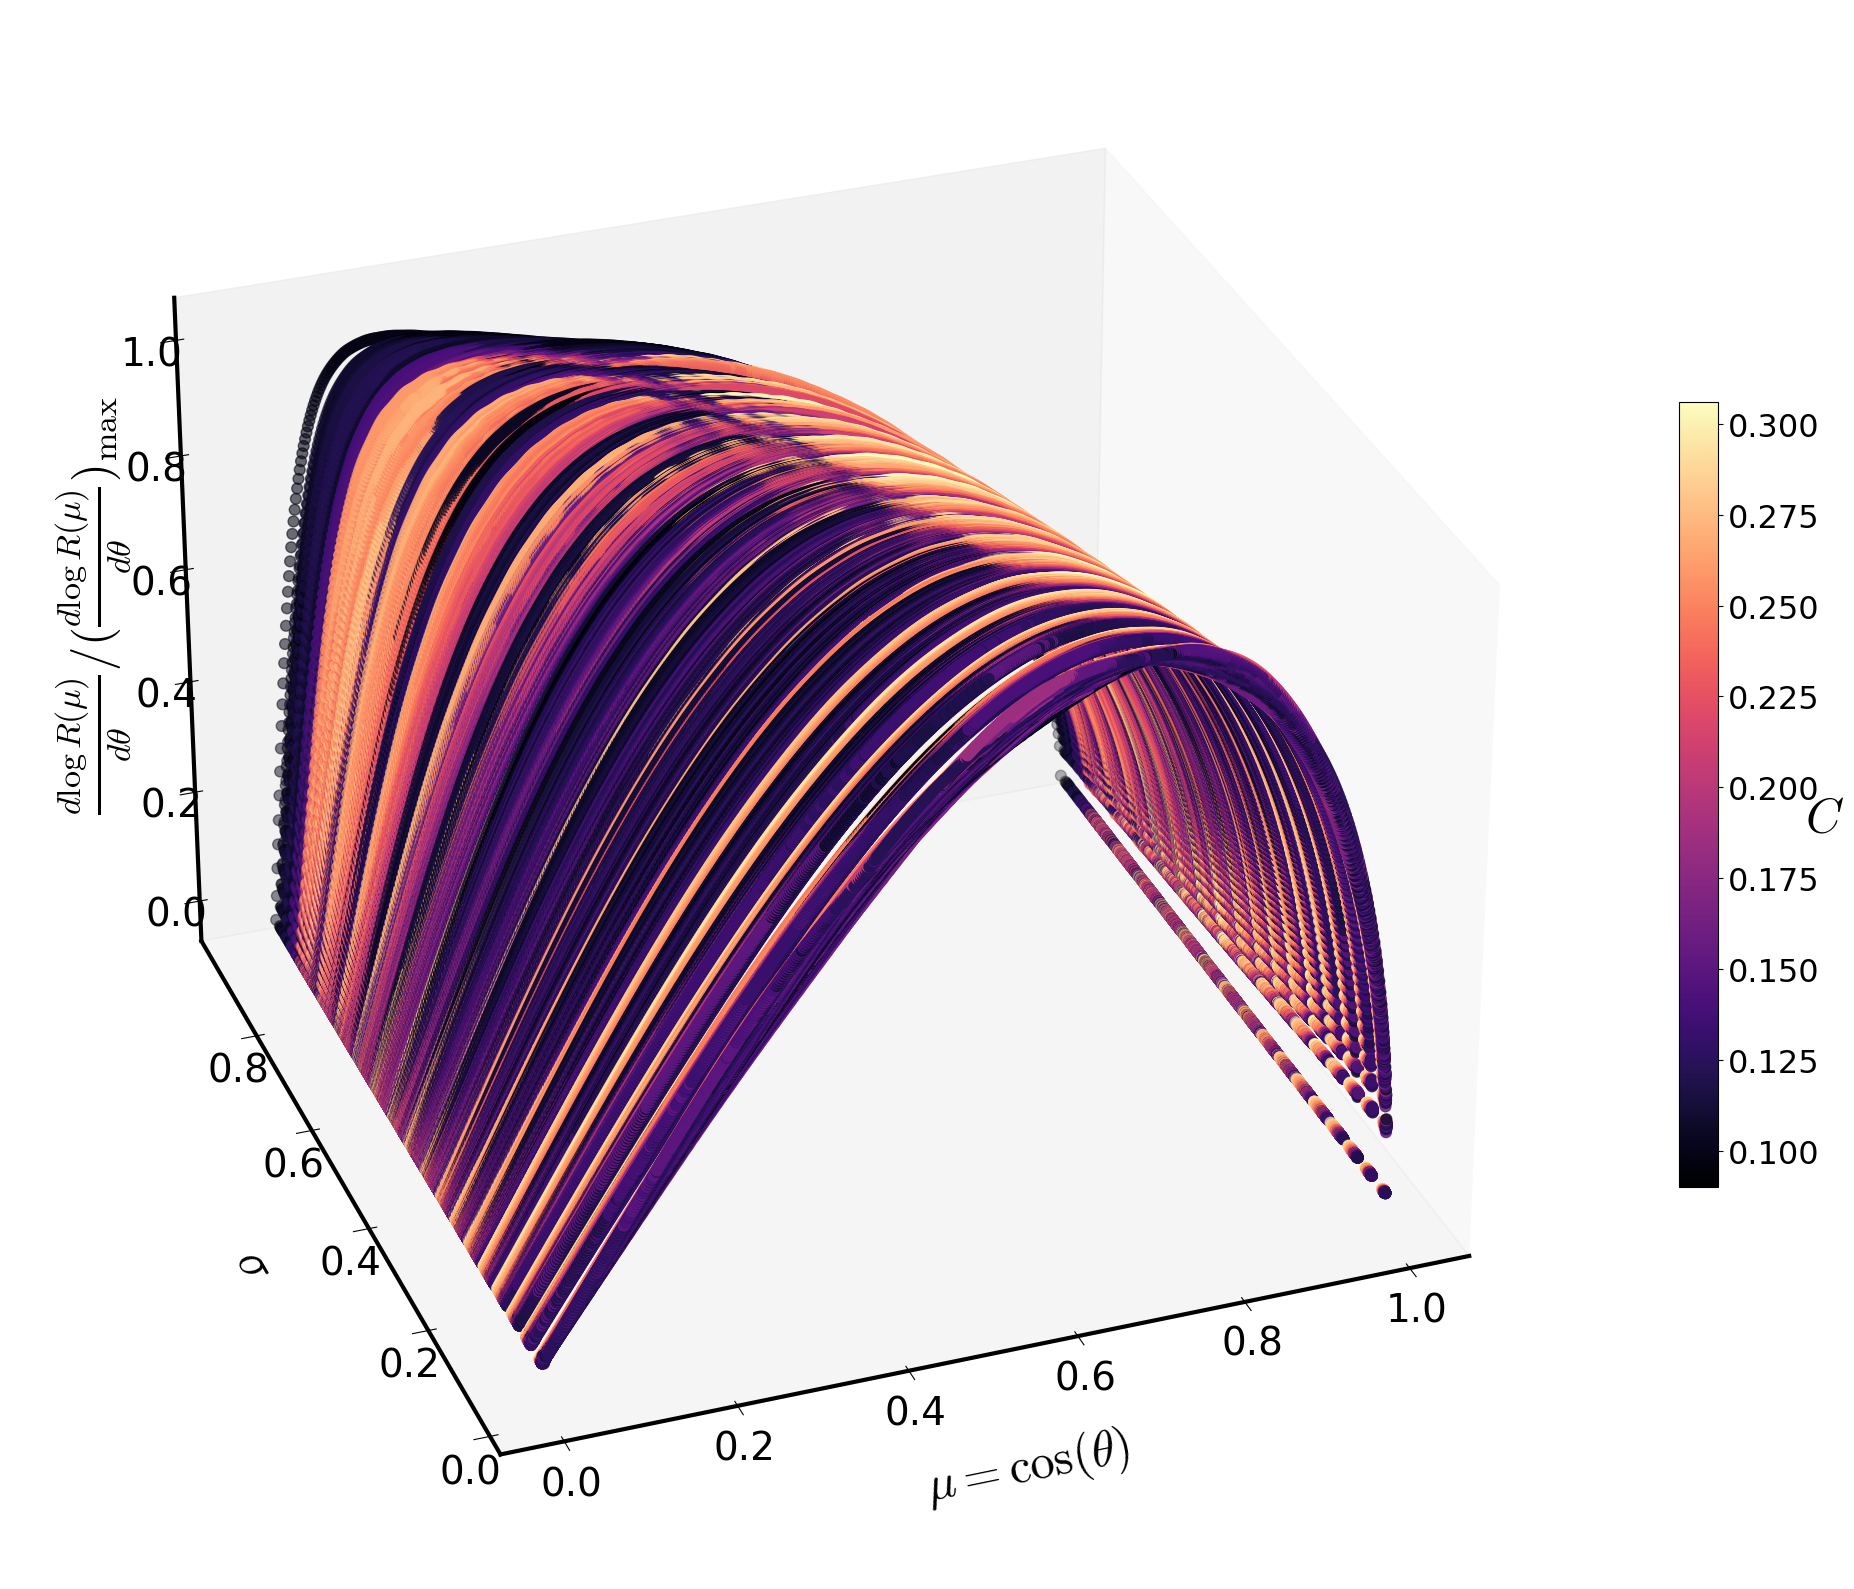

In [13]:
fig = plt.figure(figsize=(20, 16))
labels_text_size = 40
ax = fig.add_subplot(111, projection='3d')
dot_size = 60
font_size = 35
label_pad = 35
label_size = 28

# 3D scatter plot
scatter = ax.scatter(mu_var, sigma_var, dlogR_min_max, c=C_var, cmap='magma', s=60) 

cbar = plt.colorbar(scatter,  shrink=0.5, )
cbar.set_label(r'$C$', fontsize=font_size,rotation = 0)
cbar.ax.tick_params(labelsize=23)

ax.view_init(30, 250)   
    

ax.set_xlabel(r'$\mu = \cos(\theta)$', fontsize=font_size,labelpad=label_pad) 
ax.set_ylabel(r'$\sigma$', fontsize=font_size,labelpad=label_pad) 

ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$ \frac{d\log R(\mu)}{d\theta}/(\frac{d\log R(\mu)}{d\theta})_{\mathrm{max}}$', fontsize=font_size,labelpad=label_pad,rotation = 90) 
ax.zaxis.labelpad = 25
    
ax.xaxis.set_tick_params(labelsize=label_size)
ax.yaxis.set_tick_params(labelsize=label_size)
ax.zaxis.set_tick_params(labelsize=label_size)
    
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.line.set_linewidth(3)
    
ax.grid(False)
plt.tight_layout()
plt.show()

### Percentage error histogram in the test set for the suggested ANN model's optimal weights

In [9]:
ann_res = df['residual']

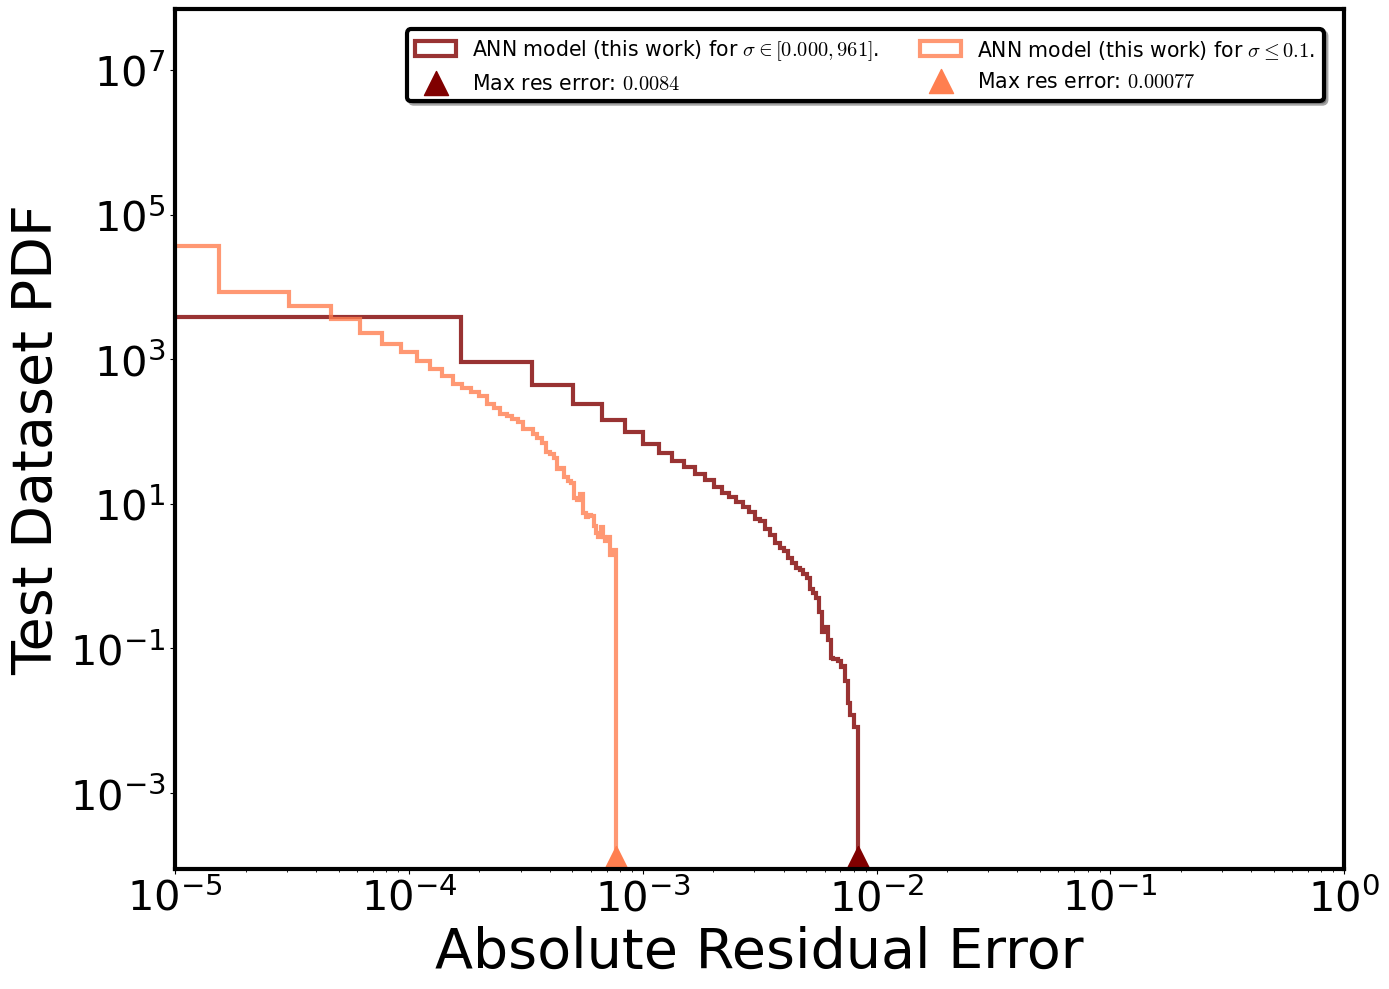

In [10]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)

xlabel = r'Absolute Residual Error'
ylabel = r'Test Dataset PDF'

plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 50
alpha = 0.8

# Histogram of errors aoociated with the proposed ANN Regression Model for at all sigma
y_reg_errors = (np.abs(df['residual'])).hist(
    density = True,
    lw =3,
    bins=bins,
    edgecolor ='maroon', 
    zorder = 1, 
    histtype='step',
    alpha = alpha, 
    label = 'ANN model (this work) for $\sigma \in [0.000,961]$.', color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)

vertical_lines = [np.abs(df['residual']).max(), None]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0],1.25e-4, color='maroon', marker='^', s=300, zorder=2, label=f"Max res error: ${np.round(np.abs(ann_res).max(),4)}$")  # Star marker


# Histogram of errors aoociated with the proposed ANN Regression Model for sigma<=0.1
y_reg_errors_2 = (np.abs(df[df['sigma']<=0.1]['residual'])).hist(
    density = True,
    lw =3,
    bins=bins,
    edgecolor ='coral', 
    zorder = 1, 
    histtype='step',
    alpha = alpha, 
    label = 'ANN model (this work) for $\sigma \leq 0.1$.', color = 'coral').autoscale(enable = True, axis = 'both', tight = True)

vertical_lines = [np.abs(df[df['sigma']<=0.1]['residual']).max(), None]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0],1.25e-4, color='coral', marker='^', s=300, zorder=2, label=f"Max res error: ${np.round(np.abs(df[df['sigma']<=0.1]['residual']).max(),5)}$")  # Star marker


# Customize plot appearance
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3.0)


# Set logarithmic scale 
plt.xscale('log')
plt.yscale('log')


# Adjust x,y-axis limits (optional, based on log scale)
plt.xlim(0.1e-4,1)
plt.ylim(9e-5,70000000)



plt.grid(False)
leg = plt.legend(loc="upper right",ncol=2, borderaxespad=1, prop={'size': 14.7}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.show()


### Distribution of absolute Residual Errors for each EoS category in the test set

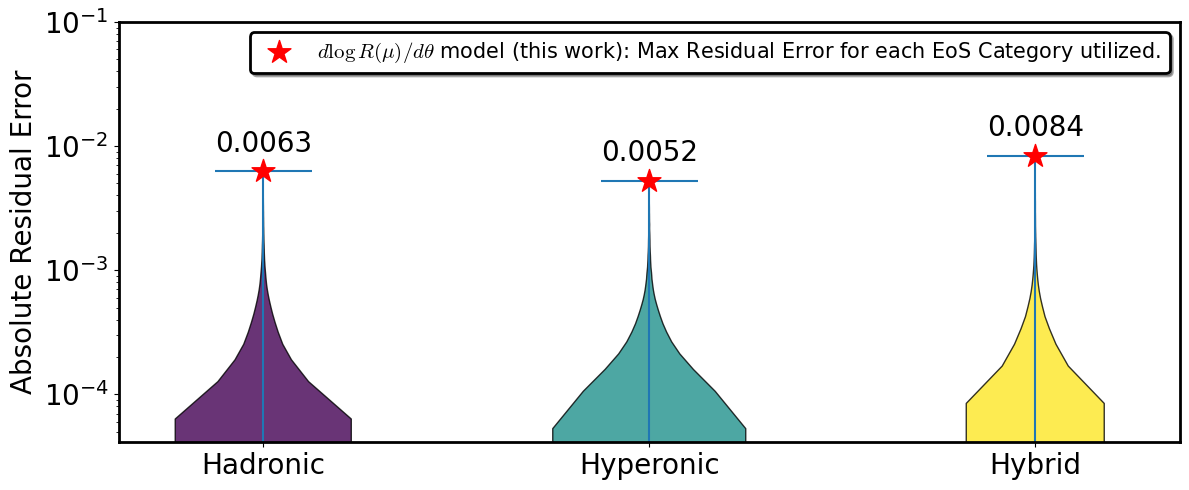

In [11]:
eos_categories = ['Hadronic', 'Hyperonic', 'Hybrid']

EoS_categories_violin_plots(
    eos_categories = eos_categories, 
    df = df, 
    eval_metric = 'residual', 
    color_map = 'viridis', 
    label = r'$d \log R(\mu)/d \theta$ model (this work): Max Residual Error for each EoS Category utilized.', 
    scale = 'log',
    y_max = 1e-1,
    y_label = r"Absolute Residual Error")

### Distribution of absolute Relative Errors for Hadronic EoSs in the test set

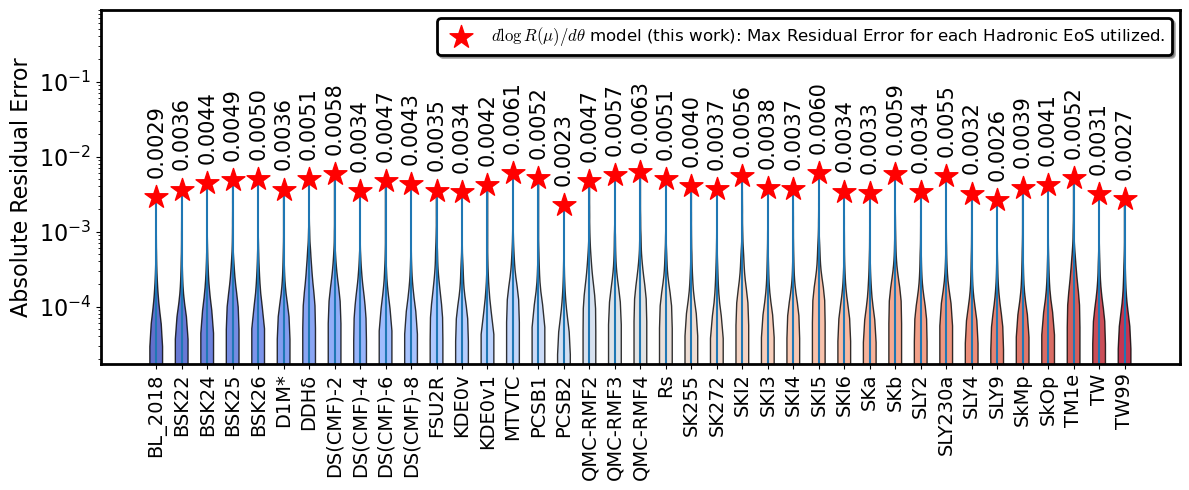

In [12]:
eos_names = [ 'BL_2018', 'BSK22', 'BSK24', 'BSK25', 'BSK26', 'D1M*', 'DDHδ','DS(CMF)-2', 'DS(CMF)-4', 'DS(CMF)-6', 'DS(CMF)-8', 'FSU2R',
       'KDE0v', 'KDE0v1', 'MTVTC', 'PCSB1', 'PCSB2', 'QMC-RMF2','QMC-RMF3', 'QMC-RMF4', 'Rs', 'SK255', 'SK272', 'SKI2', 'SKI3',
       'SKI4', 'SKI5', 'SKI6', 'SKa', 'SKb', 'SLY2', 'SLY230a', 'SLY4', 'SLY9', 'SkMp', 'SkOp', 'TM1e', 'TW', 'TW99']


EoS_class_violin_plots(eos_names = eos_names, 
                 df = df, 
                 eval_metric = 'residual', 
                 eos_class = 'Hadronic EoSs', 
                 color_map = 'coolwarm', 
                 label = r'$d \log R(\mu)/d \theta$ model (this work): Max Residual Error for each Hadronic EoS utilized.', 
                 scale = 'log',      
                 y_max = 9e-1, 
                 y_label = r"Absolute Residual Error")

### Distribution of absolute Relative Errors for Hyperonic EoSs in the test set

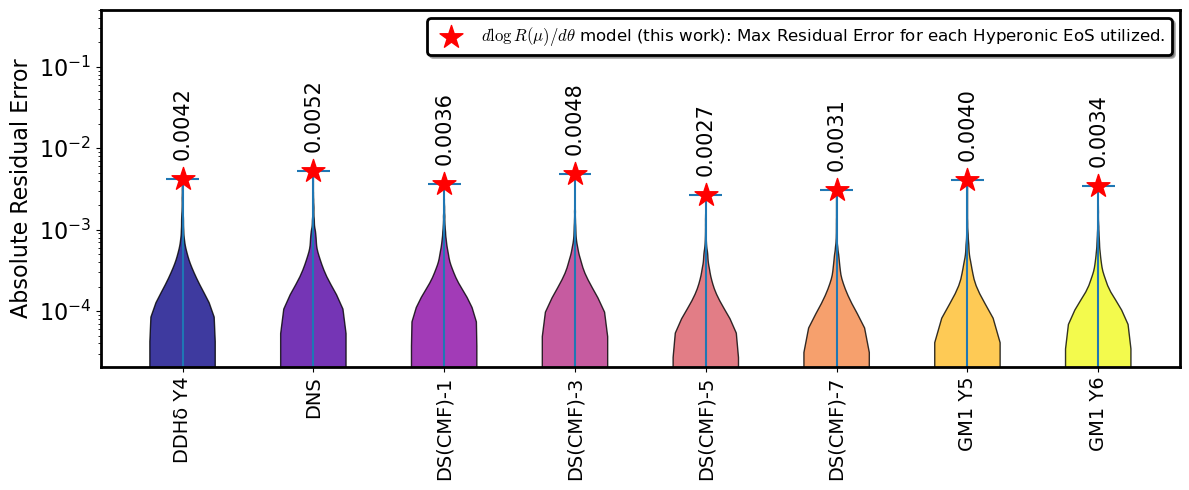

In [13]:
eos_names = [ 'DDHδ Υ4', 'DNS', 'DS(CMF)-1', 'DS(CMF)-3', 'DS(CMF)-5','DS(CMF)-7', 'GM1 Y5', 'GM1 Y6']

EoS_class_violin_plots(eos_names = eos_names, 
                 df = df, 
                 eval_metric = 'residual', 
                 eos_class = 'Hyperonic EoSs', 
                 color_map = 'plasma', 
                 label = r'$d \log R(\mu)/d \theta$ model (this work): Max Residual Error for each Hyperonic EoS utilized.', 
                 scale = 'log',      
                 y_max = 5e-1, 
                 y_label = r"Absolute Residual Error")

### Distribution of absolute Relative Errors for Hybrid EoSs in the test set

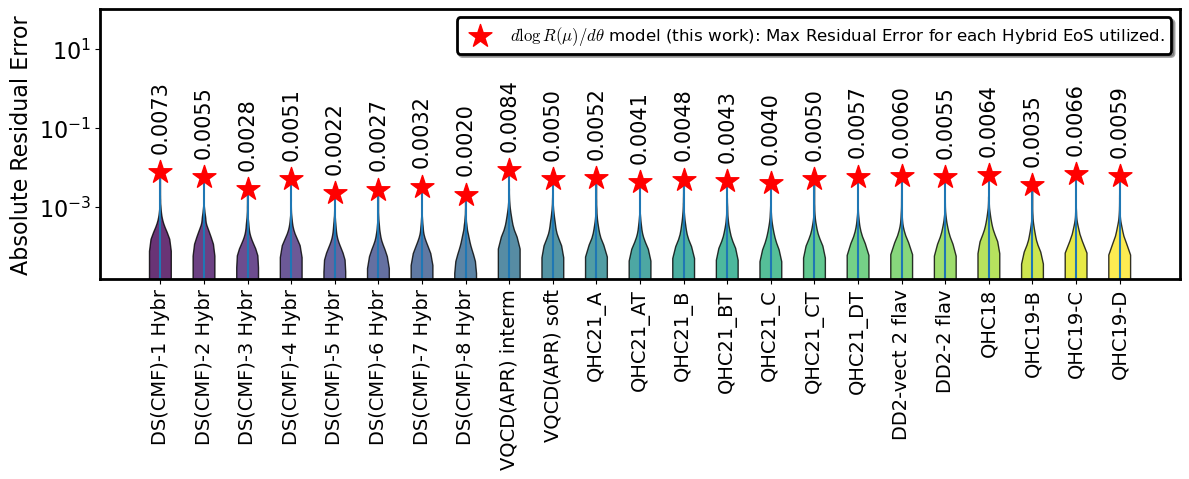

In [14]:
eos_names = ['DS(CMF)-1 Hybrid', 'DS(CMF)-2 Hybrid', 'DS(CMF)-3 Hybrid','DS(CMF)-4 Hybrid', 'DS(CMF)-5 Hybrid', 'DS(CMF)-6 Hybrid',
       'DS(CMF)-7 Hybrid', 'DS(CMF)-8 Hybrid','JJ(VQCD(APR)), intermediate', 'JJ(VQCD(APR)), soft','KBH(QHC21_A)', 'KBH(QHC21_AT)', 'KBH(QHC21_B)', 'KBH(QHC21_BT)',
       'KBH(QHC21_C)', 'KBH(QHC21_CT)', 'KBH(QHC21_DT)','OOS(DD2)-vect interaction 2 flavors', 'OOS(DD2-FRG)-2 flavors',
       'QHC18', 'QHC19-B', 'QHC19-C', 'QHC19-D']


EoS_class_violin_plots(eos_names = eos_names, 
                 df = df, 
                 eval_metric = 'residual', 
                 eos_class = 'Hybrid EoSs', 
                 color_map = 'viridis', 
                 label = r'$d \log R(\mu)/d \theta$ model (this work): Max Residual Error for each Hybrid EoS utilized.', 
                 scale = 'log',      
                 y_max = 100, 
                 y_label = r"Absolute Residual Error")

### ANN Regression Model for the star's Logarithmic derivative at surface: Evaluation on singular EOS

In [25]:
# Choose the case/EoS of your preference
# In this demo we provide indicatively for demonstration 3 EoS: 1 per star's category investigated

# Hadronic case
#file_name = './Surface models for Hadronic EOS/SLY4/'

# Hyperonic case
#file_name = './Surface models for Hyperonic EOS/DNS/'

# Hybrid case
file_name = './Surface models for Hybrid EOS/KBH(QHC21_AT)/'

In [26]:
spin = 'sigma' 
test_percentage = 0.2

rotational_path = os.path.join(file_name, 'rotational_models.zip')
static_path = os.path.join(file_name, 'static_models.zip')

df_rot_train, df_rot_test = read_zip(rotational_path, spin=spin, test_percentage=test_percentage)
df_stat_train, df_stat_test = read_zip(static_path, spin=spin, test_percentage=test_percentage)

df_train = pd.concat([df_rot_train, df_stat_train], ignore_index=True)
df_test = pd.concat([df_rot_test, df_stat_test], ignore_index=True)

# Free the memory space
del df_rot_train, df_rot_test, df_stat_train, df_stat_test

### Load the Trained Regression Model optimal weights to estimate the Logarithmic derivative at the star's surface

In [27]:
batch_size = 4096
model_path = './Model/Derivative/Derivative-model.pth'

dataloader_tr, input_dimension, np_features_tr, np_targets_tr = load_stars(df_train, batch_size=batch_size)
dataloader_ts, _, np_features_ts, np_targets_ts = load_stars(df_test, batch_size=batch_size)

regressor = Regressor(input_dimension=input_dimension, feature_scaler=feature_scaler).to(device)
regressor.set_device(device)
regressor.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
regressor.eval()

Regressor(
  (MLP): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Linear(in_features=25, out_features=10, bias=True)
    (9): LeakyReLU(negative_slope=0.1, inplace=True)
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

### Plot functions associated with residual and percentage errors

In [28]:
def plot_residuals(residual_error):
    witdh, height = 16, 6
    fontsize = 20
    labelsize = 15
    lw = 5
    
    fig, ax = plt.subplots(1, 2, figsize=(witdh, height))
    # Residual error subplot 
    ax[0].plot(residual_error, lw=lw)
    ax[0].set_xlabel(r'Datapoints', fontsize=fontsize)
    ax[0].set_ylabel(r'Residual', fontsize=fontsize)
    ax[0].tick_params(axis='both', which='both', labelsize=labelsize)
   
    ax[1].hist(residual_error, lw=lw)
    ax[1].set_ylabel(r'Datapoints', fontsize=fontsize)
    ax[1].set_xlabel(r'Residual', fontsize=fontsize)
    ax[1].tick_params(axis='both', which='both', labelsize=labelsize)

    plt.tight_layout()
    plt.show()

In [29]:
def plot_derivative(mu, model_estimation, real_targets, C, sigma):
    witdh, height = 10, 6
    fontsize = 20
    labelsize = 15
    lw = 4

    fig, ax = plt.subplots(figsize=(witdh, height))
    ax.plot(mu, model_estimation, lw=lw, c='maroon', label='ANN model (this work)')
    ax.scatter(mu, real_targets, c='black', s=20, marker='o', label='Numerical Data')
    plt.ylim((1-0.1)*real_targets.min(), (1+0.1)*real_targets.max())
    plt.xlabel(r'$\mu = \cos(\theta)$', fontsize=fontsize)
    plt.ylabel(r'$d\log R(\mu)/d\theta$', fontsize=fontsize)
    plt.title(f'NS model with C={round(C,3)}, $\sigma$ = {round(sigma,3)}')
    plt.legend(loc='best', prop={'size':fontsize}, shadow=True, fontsize='large')
    ax.tick_params(axis='both', which='both', labelsize=labelsize)

    leg = plt.legend(loc="best", ncol=1, borderaxespad=1, prop={'size': 15.},  shadow=True, fontsize="large")
    leg.get_frame().set_linewidth(3.0)
    leg.get_frame().set_edgecolor('black')
    plt.tight_layout()
    plt.show()

#### Universal relations suggested in this work for the parameters $e$, $R_p/R_e$ and $(d\log R/d \theta)_{\mathrm{max}}$

In [30]:
#def eccentricity(C, sigma):
#    return (
#        -99.173162625833 * C**5 +68.055729822908 * C**4 * sigma + 137.191420602024 * C**4 +12.9349885313244 * C**3 * sigma**2 -
#        57.474308297241 * C**3 * sigma -67.7948794729071 * C**3 -9.03315944594535 * C**2 * sigma**3 + 8.08346062523145 * C**2 * sigma**2 +
#        9.19713339469957 * C**2 * sigma + 14.9006458417145 * C**2 + 4.84885244516378 * C * sigma**4 -
#        6.44626099699536 * C * sigma**3 +2.75499036217858 * C * sigma**2 -
#        1.3329369261108 * C * sigma - 1.52533604289959 * C + 4.71450473450295 * sigma**5 -
#        13.8547513636472 * sigma**4 + 15.4712200610891 * sigma**3 - 8.71280504897915 * sigma**2 +
#        3.0422989983075 * sigma + 0.182560763719325
#    )

#def R_pole(R_e, C, sigma):
#    return (
#        R_e*(68.7151320054541 * C**5 -117.228807812831 * C**4 * sigma -
#        71.6699195745365 * C**4 - 8.83436790963497 * C**3 * sigma**2 +
#        90.4556842423828 * C**3 * sigma + 28.980101203154 * C**3 -
#        2.1673404784385 * C**2 * sigma**3 + 4.94947873047332 * C**2 * sigma**2 -
#        21.6125323056704 * C**2 * sigma - 5.6347743027431 * C**2 + 0.274033536311414 * C * sigma**4 +
#        1.01941492279495 * C * sigma**3 - 1.95940441780677 * C * sigma**2 +
#        2.60894540594265 * C * sigma + 0.522844117974324 * C + 0.627942468515494 * sigma**5 -
#        1.16678579309014 * sigma**4 + 0.508122852358802 * sigma**3 + 0.371402374708614 * sigma**2 -
#        0.784944132327725 * sigma + 0.981279105367004)
#    )

#def dLogR_dtheta_Max(C, sigma, R):
#    return (
#        -0.403276601295374 * C**3 +0.661519097793562 * C**2 * sigma +
#        2.57434191155828 * C**2 * R -2.23108454811518 * C**2 -
#        8.67625739742325 * C * sigma**2 - 39.6796750693722 * C * sigma * R +
#        38.4663786235779 * C * sigma - 45.0567823427512 * C * R**2 +
#        87.0956609308423 * C * R - 42.1349805655397 * C +
#        4.07991541887412 * sigma**3 + 30.4880078788823 * sigma**2 * R -
#        27.2418077134724 * sigma**2 + 72.1353182129003 * sigma * R**2 -
#        130.455828718591 * sigma * R + 58.5590616356724 * sigma +
#        53.9663039265715 * R**3 - 146.858522848505 * R**2 +
#        131.341936932855 * R - 38.4414384733067
#    )

### Select NS for estimating the LOgarithmic derivative with the associated residuals 

In [31]:
# Select Set (Train/Test)
is_train = True # True or False

# Select your favourite Star
star_index = 1

# Do not change
low = star_index * N_MU
high = (star_index + 1) * N_MU

select_set = lambda is_train, df_train, df_test: df_train if is_train else df_test
select_features = lambda is_train, np_features_tr, np_features_ts: np_features_tr if is_train else np_features_ts
select_targets = lambda is_train, np_targets_tr, np_targets_ts: np_targets_tr if is_train else np_targets_ts
    
# Select Set (Train/Test)
df_set = select_set(is_train, df_train, df_test)
features = select_features(is_train, np_features_tr, np_features_ts)
targets = select_targets(is_train, np_targets_tr, np_targets_ts)

# Model's log-der estimation using the suggested ANN model
estimation = regressor.predict(features[low:high]).ravel().astype(np.float64) 
max_ = df_set['dlogR_dtheta'].iloc[low:high].max()

##########################################################
# max_ taken from the universal relation suggested
#C = df_set['C'].iloc[low]
#sigma =  df_set['sigma'].iloc[low]
#R_e = df_set['Req_num'].iloc[low]
#r_star = R_pole(R_e, C, sigma)/R_e
#max_ = dLogR_dtheta_Max(C, sigma, r_star)
###########################################################

# Static case
model_estimation = estimation * max_ 
real_targets = targets[low:high] * max_

real_targets = real_targets.ravel().astype(np.float64) 
    
mu = df_set['cos(theta)'].iloc[low:high]

### Residual error computation

In [32]:
residual_error = model_estimation - real_targets

### Error distributions for the logarithmic derivative at surface of singular NS configuration

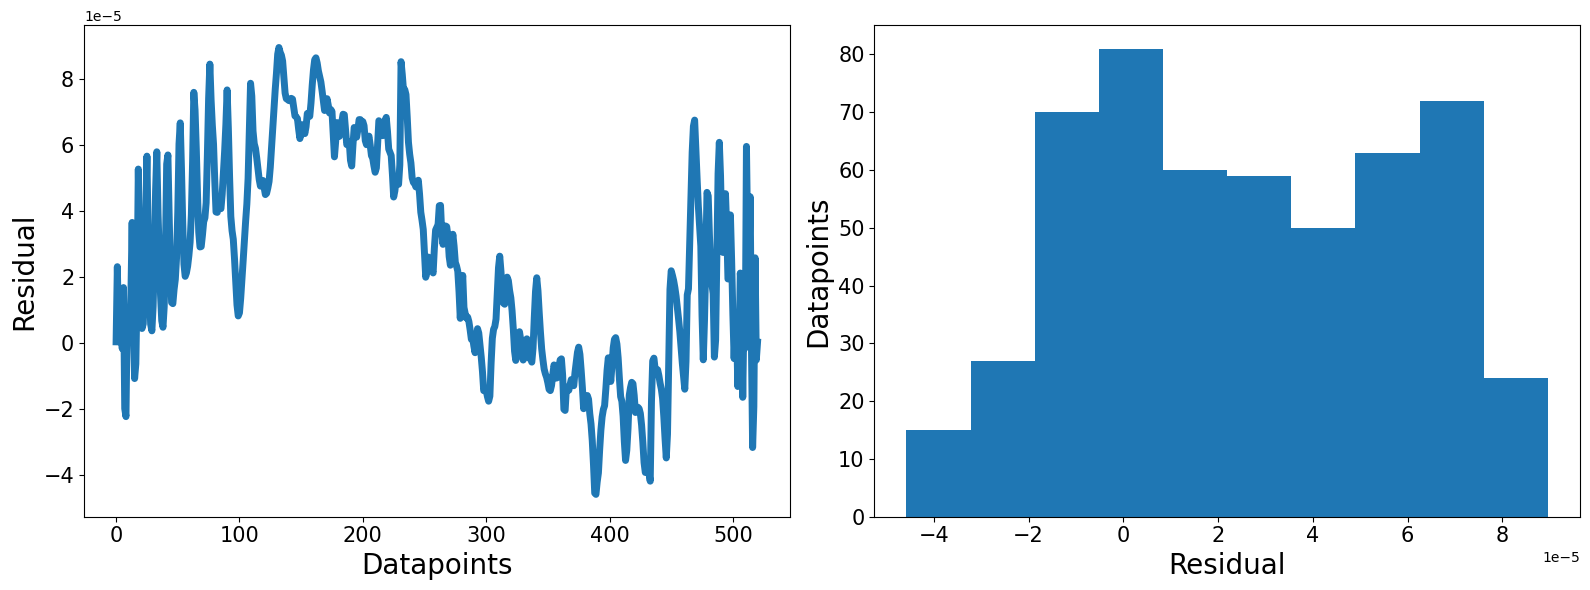

In [33]:
plot_residuals(residual_error)

### Logarithmic derivative at surface for an indicative NS configuration

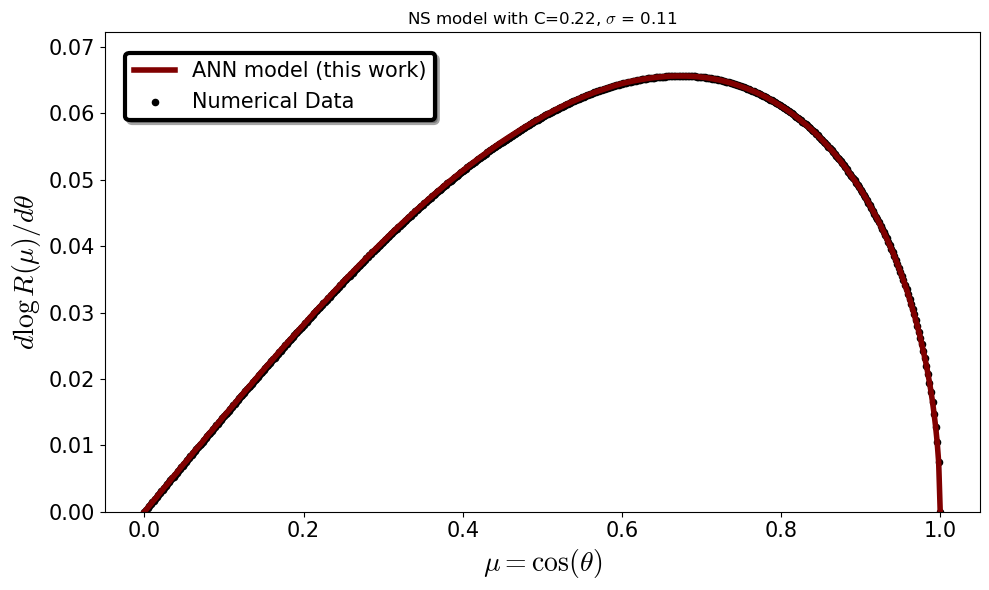

In [34]:
plot_derivative(mu, model_estimation, real_targets, df_set['C'].iloc[low], df_set['sigma'].iloc[low])

### Visualization of the all the log-derivative curves in the selected set (Train/Test) dataset for the specific EOS loaded

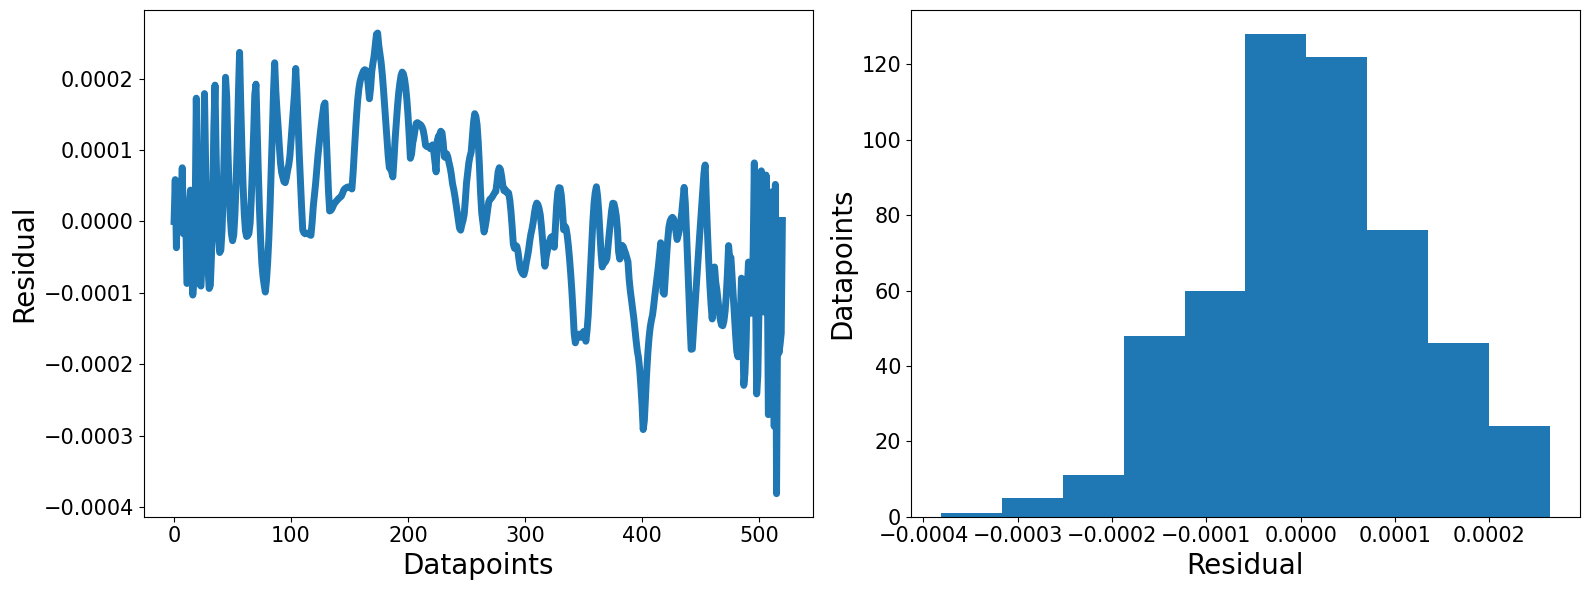

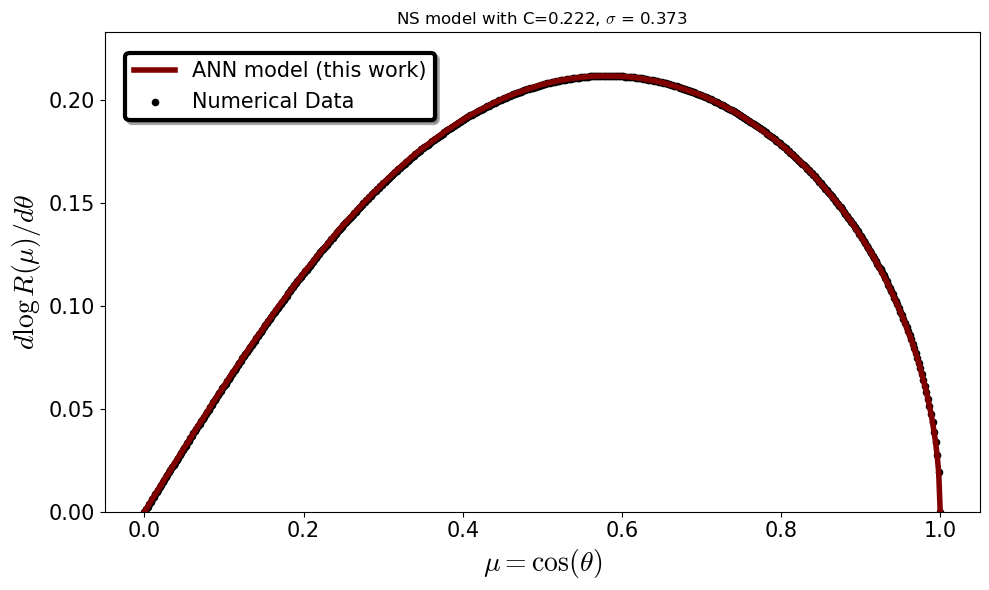

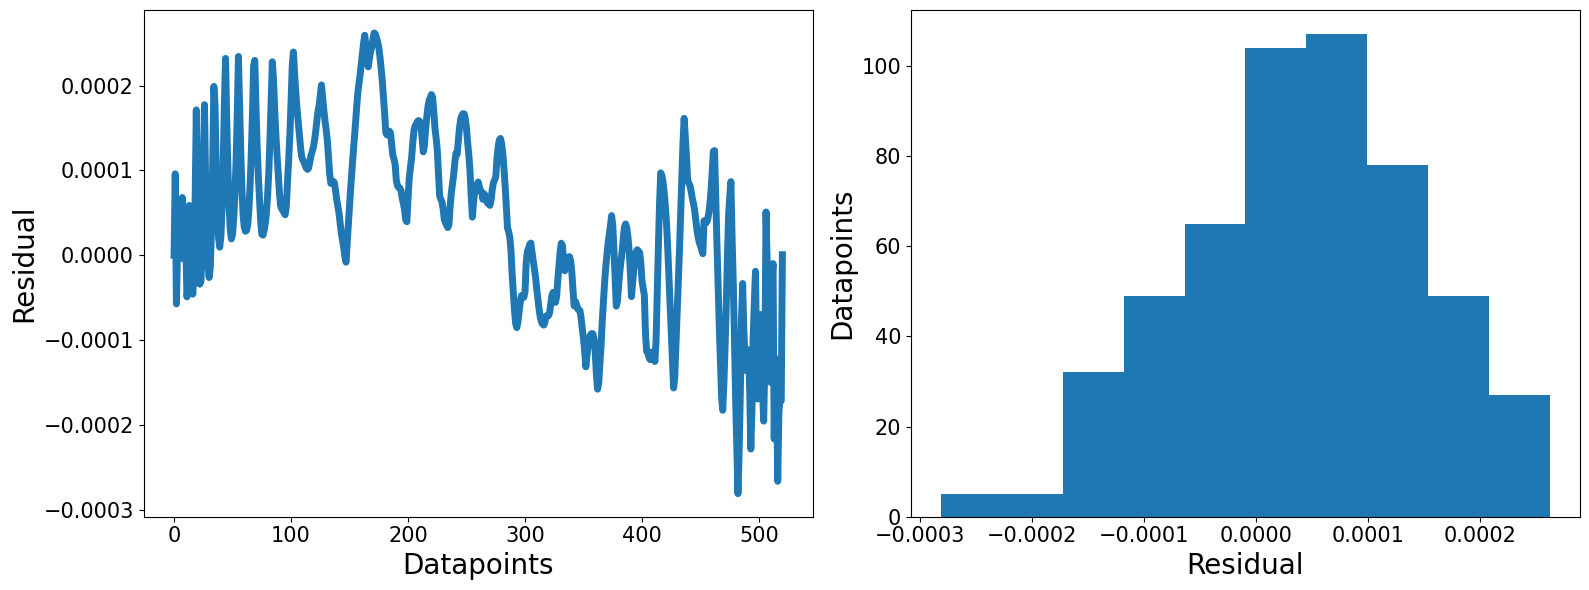

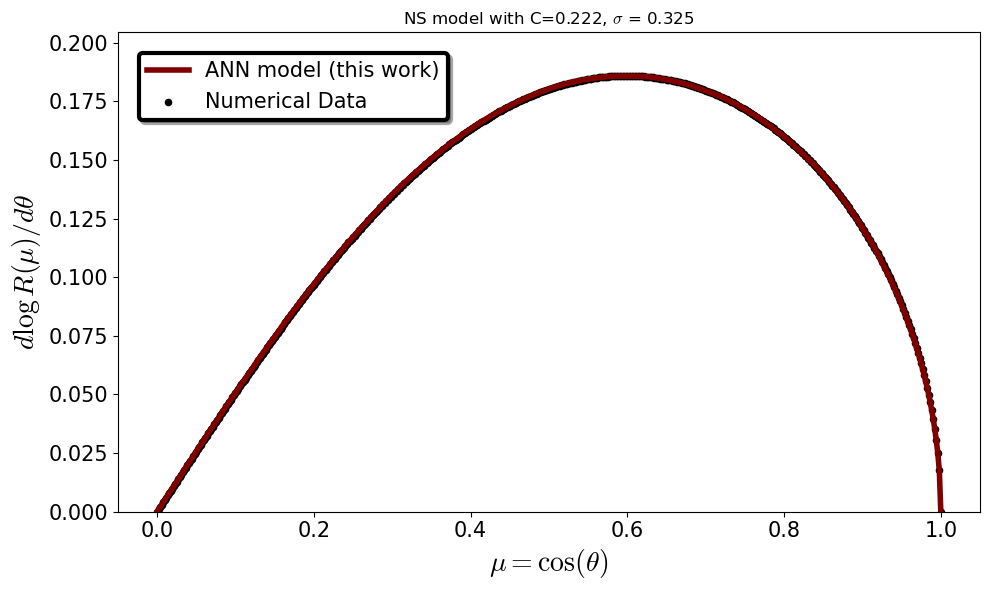

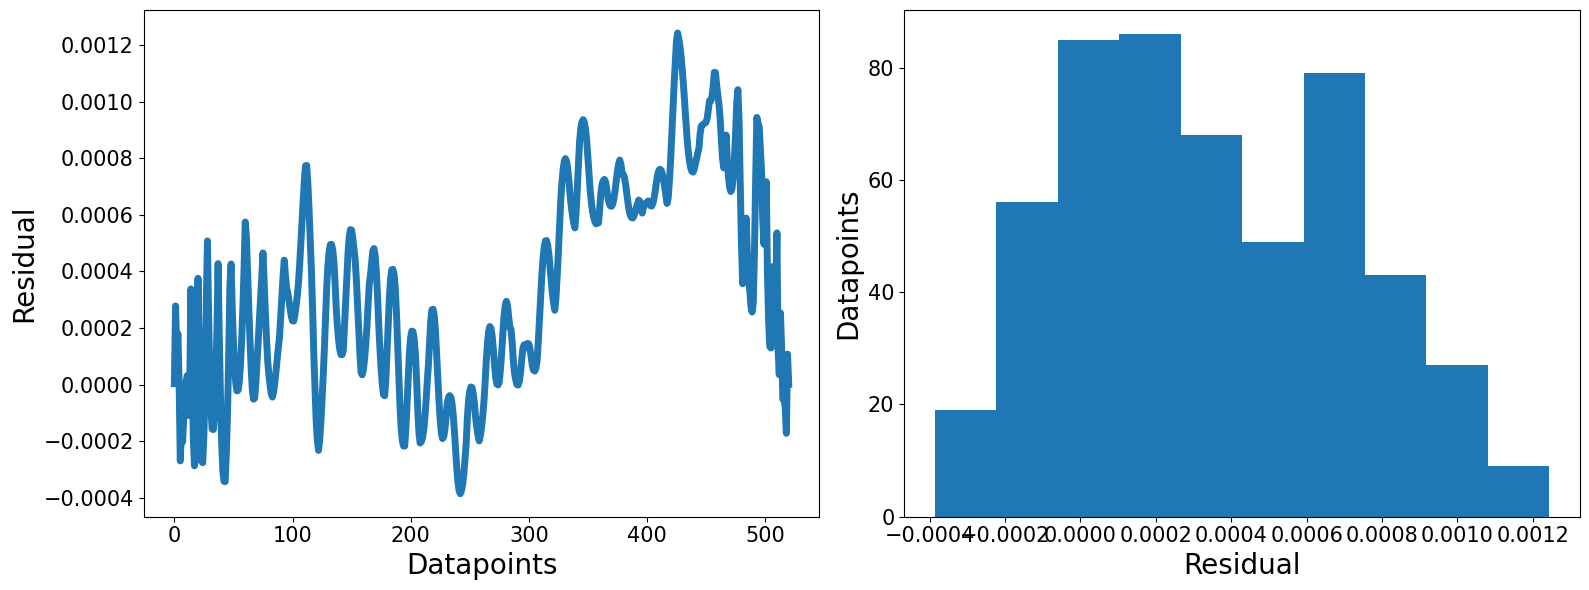

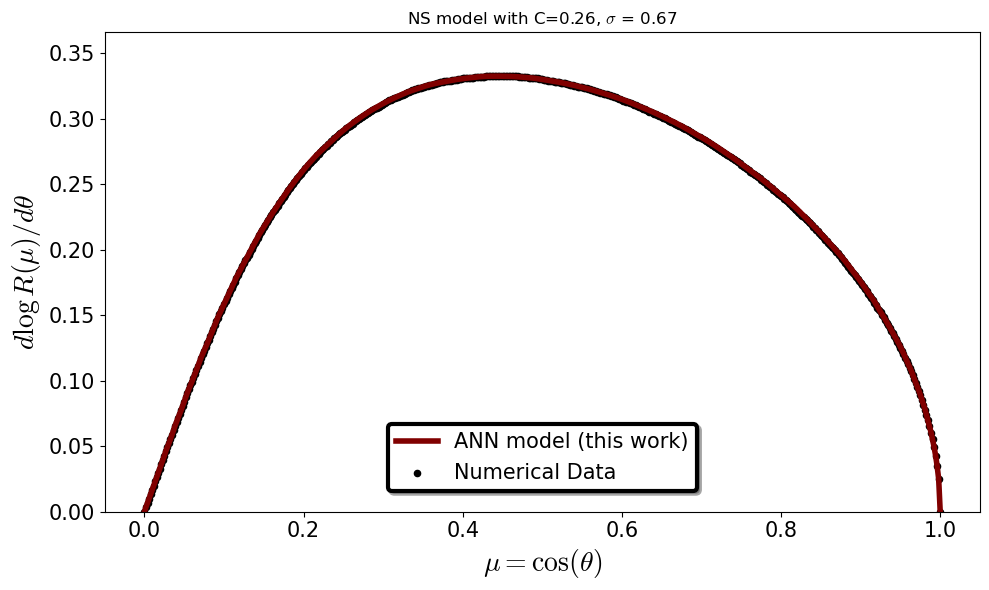

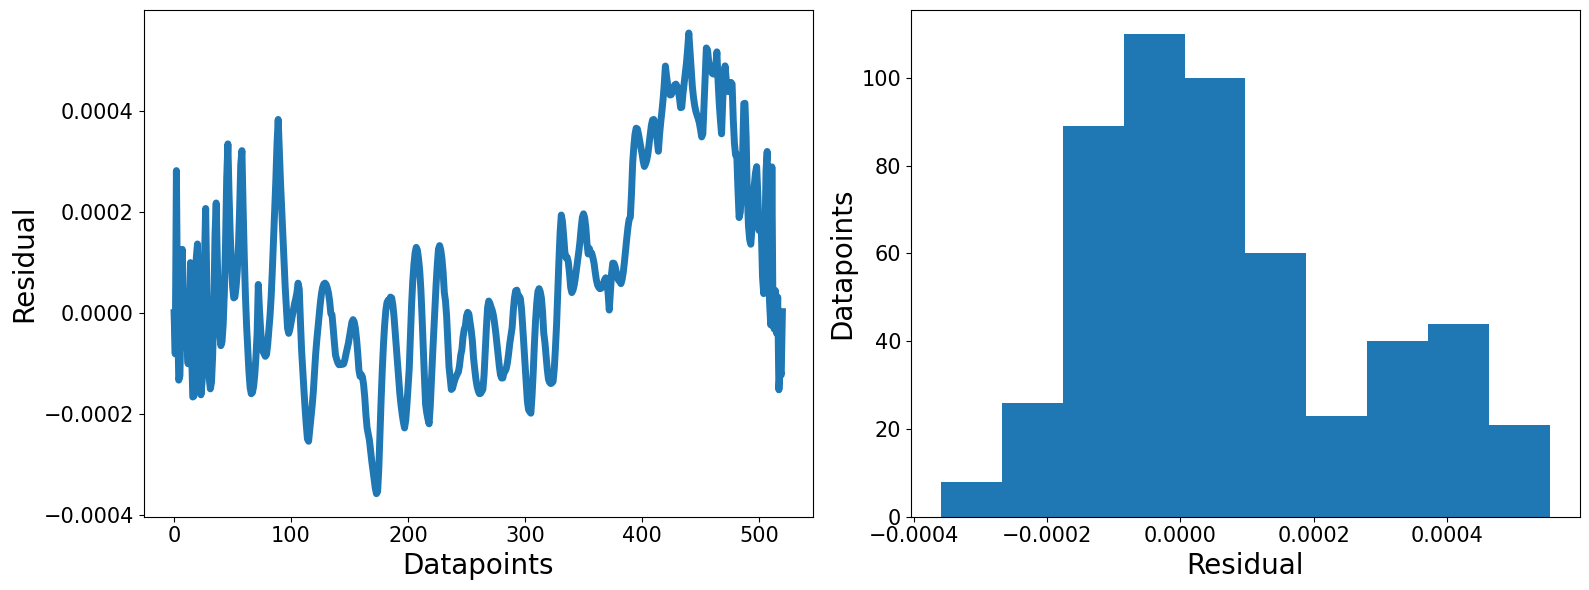

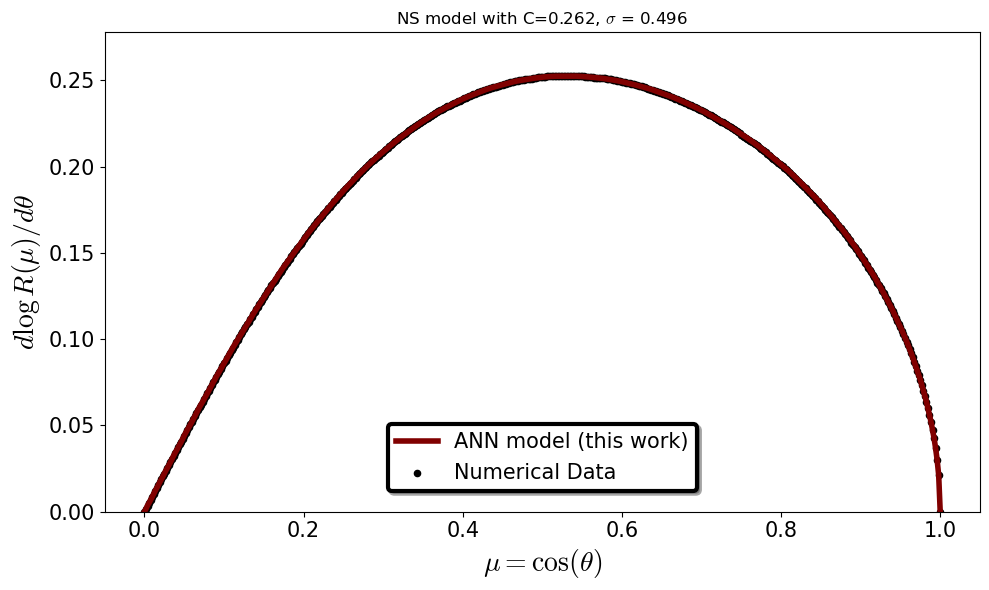

KeyboardInterrupt: 

In [35]:
# Select Training or test set
is_train = False # True or False

select_set = lambda is_train, df_train, df_test: df_train if is_train else df_test
select_features = lambda is_train, np_features_tr, np_features_ts: np_features_tr if is_train else np_features_ts
select_targets = lambda is_train, np_targets_tr, np_targets_ts: np_targets_tr if is_train else np_targets_ts
    
# Select Set (Train/Test)
df_set = select_set(is_train, df_train, df_test)
features = select_features(is_train, np_features_tr, np_features_ts)
targets = select_targets(is_train, np_targets_tr, np_targets_ts)
    
for star_index in range(0, 100):
    # Do not change
    low = star_index * N_MU
    high = (star_index + 1) * N_MU
    
    ############# C and sigma for each star ######################################
    C = df_set['C'].iloc[low]
    sigma = df_set['sigma'].iloc[low]
    R_e = df_set['Req_num'].iloc[low]
    ##############################################################################
    
   # Select and estimate star surface
    estimation = regressor.predict(features[low:high]).ravel().astype(np.float64) 
    max_ = df_set['dlogR_dtheta'].iloc[low:high].max()
    
    ##########################################################
    # max_ taken from universal relation extracted
    #r_star = R_pole(R_e, C, sigma)/R_e
    #max_ = dLogR_dtheta_Max(C, sigma, r_star)
    ###########################################################
    
    
    model_estimation = estimation * max_ 
    real_targets = targets[low:high] * max_

    real_targets = real_targets.ravel().astype(np.float64) 
    mu = df_set['cos(theta)'].iloc[low:high]
    
    residual_error = model_estimation - real_targets
    
    plot_residuals(residual_error)
    plot_derivative(mu, model_estimation, real_targets, C, sigma)